# Agent environment with bitflipping actions

## Neural network model details
 * Input: $\mathbb{R}^n$ vector representing the bit sequence (e.g. $00011 \sim (0, 0, 0, 1, 1)$)
 * Output: $\mathbb{R}^{n}$ vector of the $Q$-values
    * The index corresponds to integer $\geq 0$ representing the index of the bit being flipped
    * So $\text{model}(s)[a]$ will be the $Q$-value
 * Architecture: Simple MLP

## Training method
Simple DQN with replay
   * Exploration step -> update Q network -> validation step

**Exploration step**
We initialize 16 agents starting at random starting states (for each agent). The actions will be according to the DQN agent, and with probability $\epsilon$, a random action will be picked uniformly. We add this to the experience buffer.

**Update Q network**
Update the DQN to match Bellman's equation using a randomly sampled batch size ($=128$), and this is done with gradient descent.

**Validation step**
Access the performance of the learnt policy. Initialize 1024 random starting states, and let the agent fully decide the actions (we do not replace actions with probability $\epsilon$ with uniform distribution). Since this is the validation step, this should not interfere with the training process, and the experience buffer won't be updated.


## Notes
For an optimal agent, $E[\text{steps}] = \frac{1}{2^n}\sum_{k=0}^n \dbinom{n}{k}k = \frac{n}{2}$. We expect the average number of steps to be close to $\frac{n}{2}$ if an optimal agent is chosen.

In [1]:
from src.environments.env_bit_sequence_flipping import FlippingBitSequenceEnv
from src.agents.agent_dqn import DQNAgent
from src.models.model_dqn_bitflipping import BitFlippingDQNNetwork
from src.models.buffer_bitflipping import BufferBitflipping

import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0")

def train_DQN_agent(n: int, device: torch.device,
    episodes: int=10000, num_explore_agents: int=16, num_valid_agents: int=1024,
    batch_size: int=2048) -> None:

    # initialize environment, model and agent
    env = FlippingBitSequenceEnv(n, device, fix_original_state=True)
    model = BitFlippingDQNNetwork(n)
    model.to(device)
    running_model = BitFlippingDQNNetwork(n)
    running_model.to(device)
    buffer = BufferBitflipping(n, device=device, no_repeat=True)
    agent = DQNAgent(model=model, running_model=running_model,
                     buffer=buffer, device=device,
                     action_space_size=n)
    
    target_value = n / 2 if not env.fix_original_state else env.get_initial_distance()

    success_rates = []
    steps_to_success = []
    loss_values = []
    for e in tqdm(range(episodes)):
        # initial state is numpy array, convert to torch tensor
        state = env.reset(num_agents=num_explore_agents)

        # let agent act for at most 2n steps
        for _ in range(2 * n):  # max time steps
            with torch.no_grad():
                action = agent.act(state)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                agent.remember(state[prev_step_ongoing, :].cpu().numpy(), action[prev_step_ongoing].cpu().numpy(),
                               reward[prev_step_ongoing].cpu().numpy(), next_state[prev_step_ongoing, :].cpu().numpy(), done[prev_step_ongoing].cpu().numpy())
                state = next_state
                if done.all():
                    break
        
        # replay to update Q network
        loss = agent.replay(batch_size=batch_size, opt_steps=1)

        # now run the agent for at most 2n steps to see if it has learned (without random exploration, and without affecting the replay buffer)
        # we use random initial states
        state = env.reset(num_agents=num_valid_agents)
        agent_steps_to_success = np.ones(num_valid_agents)
        for step in range(2 * n):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=False)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                state = next_state

                if step == 0: # if by random chance the agent is already done in the first step, we need to handle this case
                    agent_steps_to_success[prev_done.cpu().numpy()] = 0
                agent_steps_to_success[~done.cpu().numpy()] += 1
                if done.all():
                    break
        success_rate = ((done.sum().item() + 0.0) / num_valid_agents)
        avg_steps_to_success = agent_steps_to_success.mean()
        success_rates.append(success_rate)
        steps_to_success.append(avg_steps_to_success)
        loss_values.append(loss)

        if e > 100 and (np.array(steps_to_success[-100:]) < target_value + 1).all():
            print("Early stopping at episode", e)
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
            break

        if (e + 1) % 100 == 0:
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
    
    # plot success rates and steps to success over episodes
    plt.figure(figsize=(24, 16))
    plt.subplot(2, 3, 1)
    plt.plot(success_rates)
    plt.xlabel("Episodes")
    plt.ylabel("Success rate")
    plt.title("Success rate over episodes")
    plt.subplot(2, 3, 2)
    plt.plot(steps_to_success)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes")
    plt.subplot(2, 3, 3)
    plt.plot(steps_to_success)
    plt.ylim(target_value - 1, target_value + 1)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes (Zoom)")
    plt.subplot(2, 3, 4)
    plt.plot(loss_values)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes")
    plt.subplot(2, 3, 5)
    plt.plot(loss_values)
    plt.ylim(0.0, 0.01)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes (Zoom)")
    plt.show()

    print(buffer.buffer_size)

# Experiments

$n=2$, optimal agent achieved as steps $\sim 1$

Initialized FlippingBitSequenceEnv with n = 2. Randomly picked target: tensor([0, 1], device='cuda:0')
Initial distance to target: 1
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 102/10000 [00:01<01:45, 93.70it/s]


Episode: 99/10000, Epsilon: 0.9047921471137096, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.000007
Early stopping at episode 102
Episode: 102/10000, Epsilon: 0.9020804841440176, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.000004


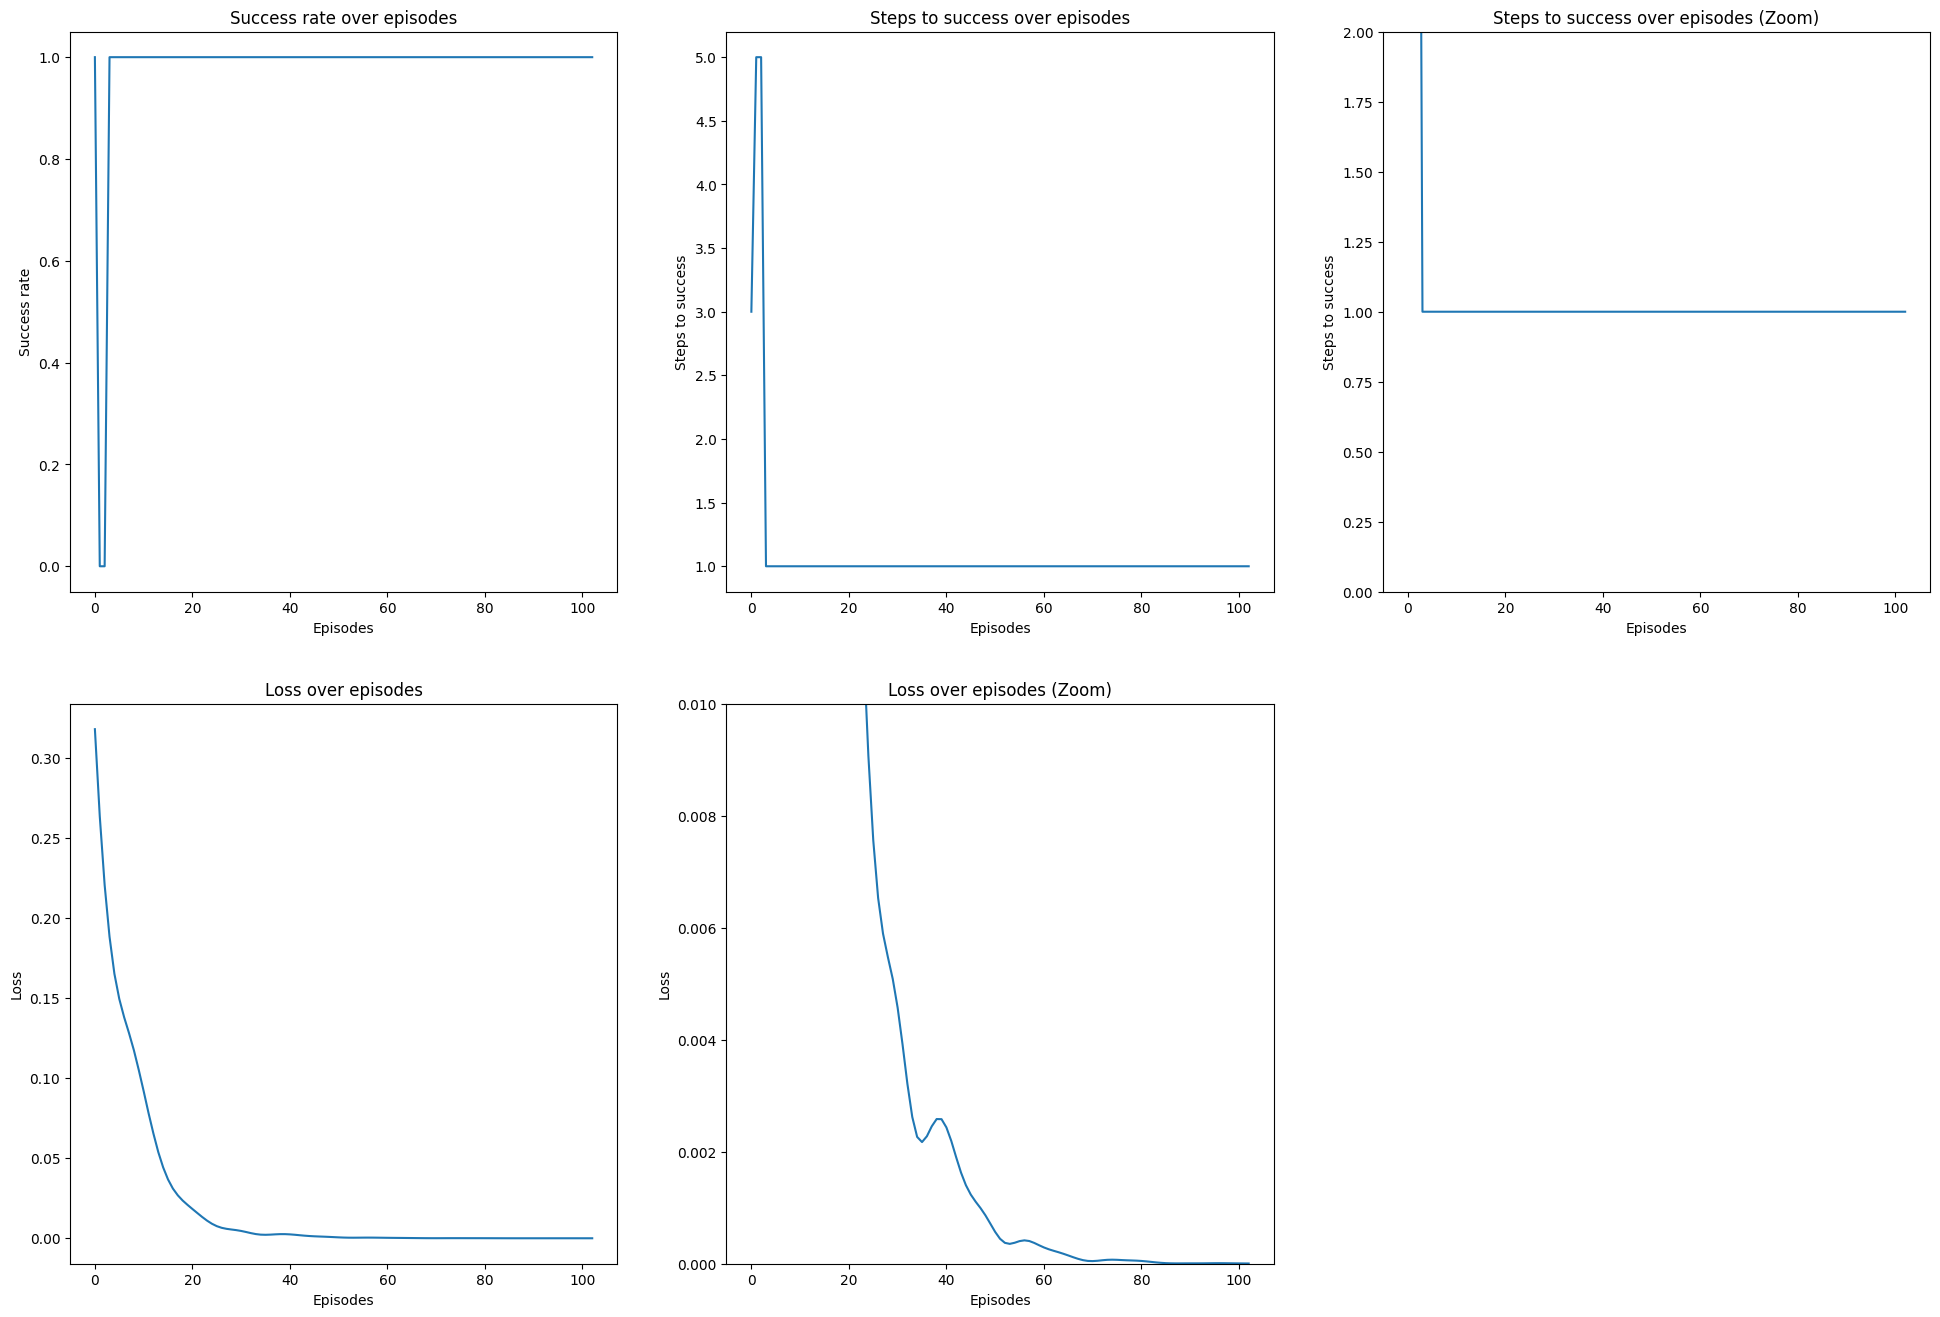

6


In [2]:
train_DQN_agent(2, device=device)

$n=3$, optimal agent achieved as steps $\sim \frac{3}{2}$

Initialized FlippingBitSequenceEnv with n = 3. Randomly picked target: tensor([1, 0, 0], device='cuda:0')
Initial distance to target: 1
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 101/10000 [00:01<01:54, 86.14it/s]


Episode: 99/10000, Epsilon: 0.9047921471137096, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.001118
Early stopping at episode 101
Episode: 101/10000, Epsilon: 0.9029834676116293, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.001029


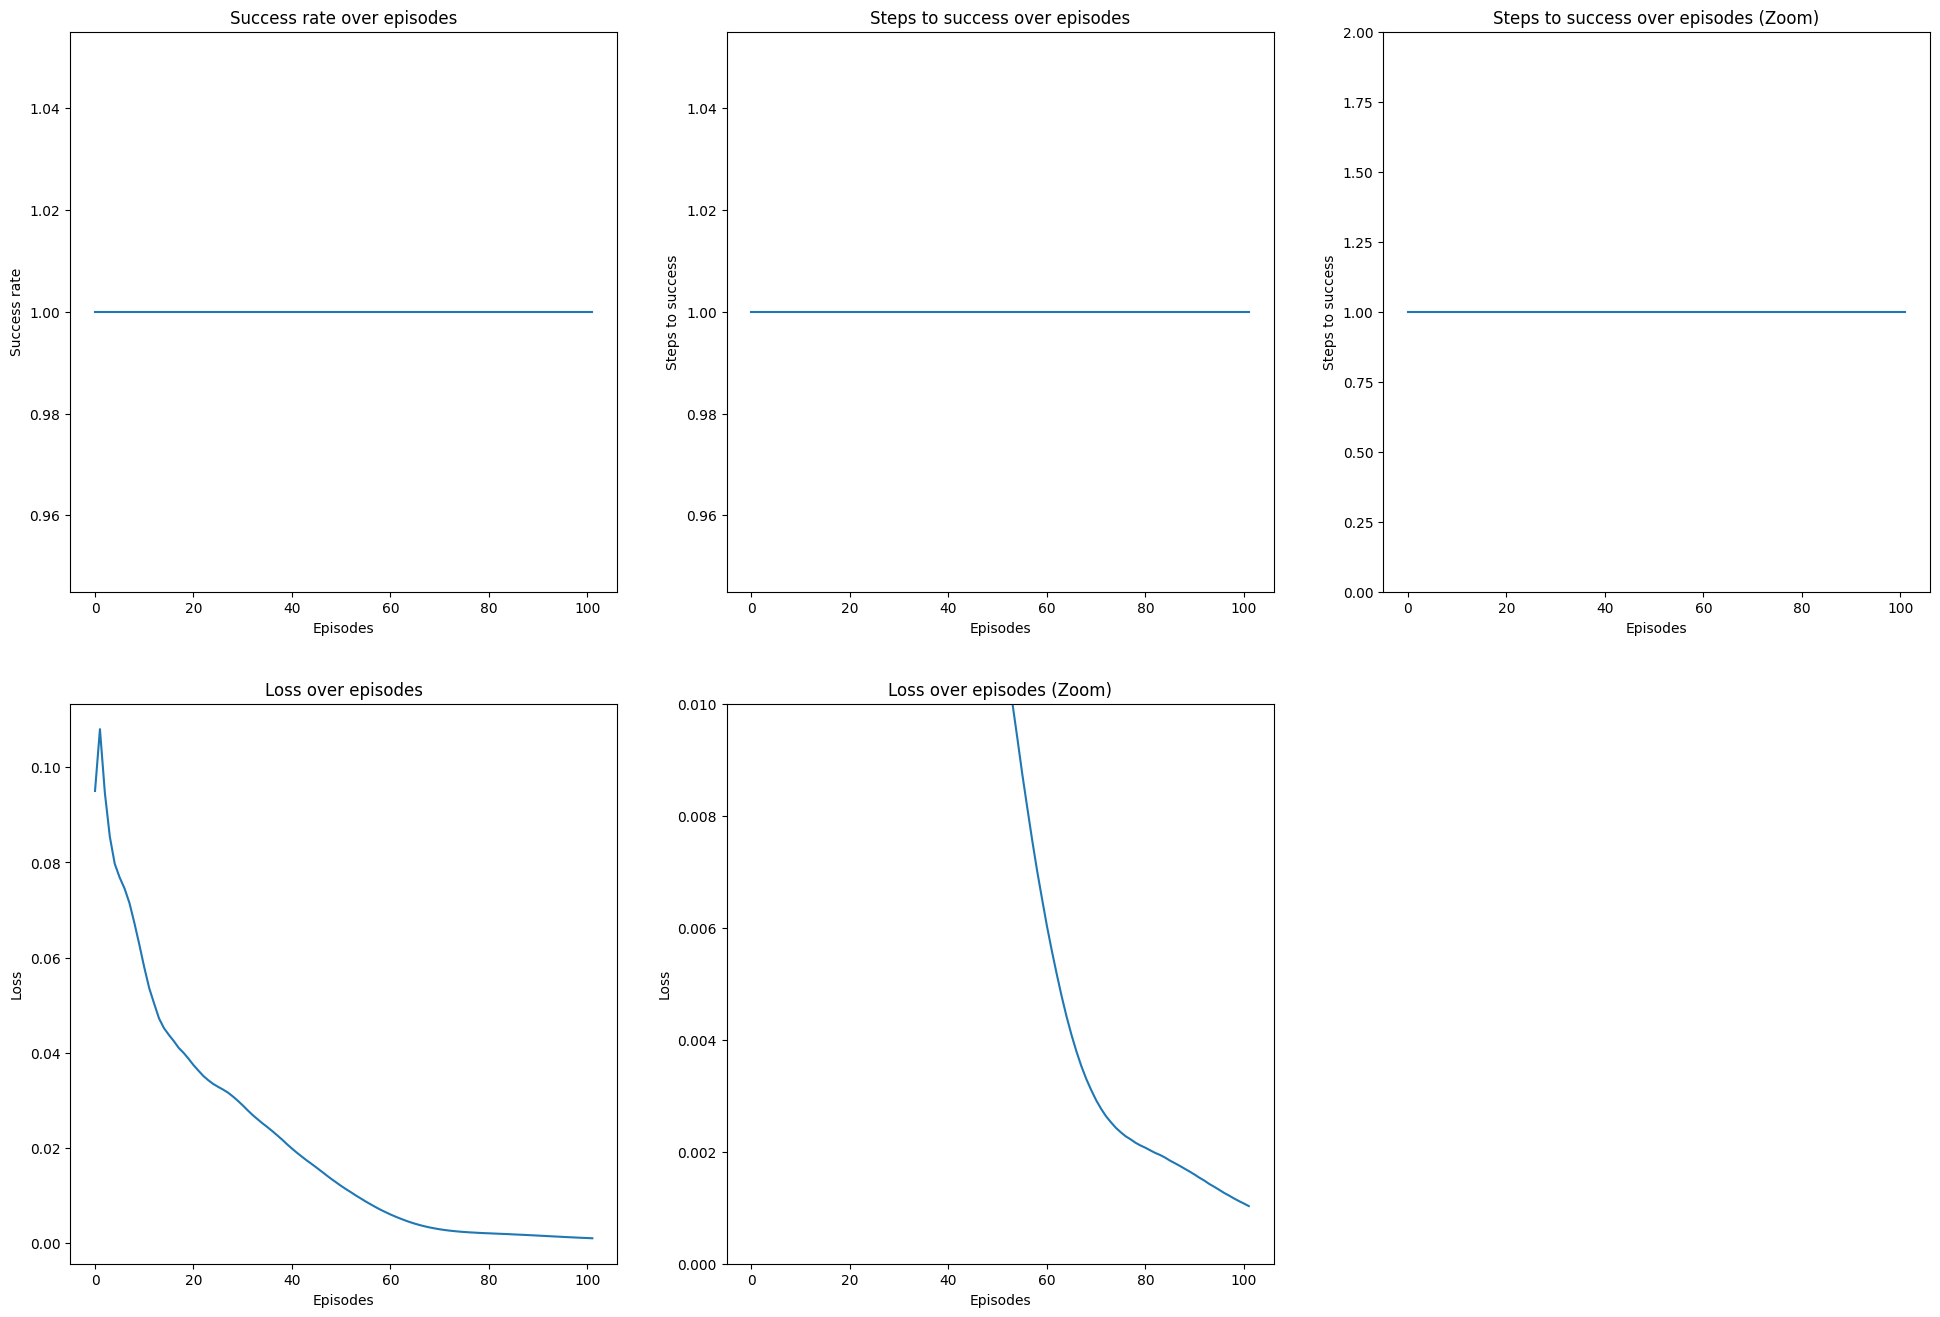

21


In [3]:
train_DQN_agent(3, device=device)

$n=6$, optimal agent achieved as steps $\sim 3$

Initialized FlippingBitSequenceEnv with n = 6. Randomly picked target: tensor([1, 0, 1, 0, 1, 1], device='cuda:0')
Initial distance to target: 3
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 108/10000 [00:02<03:27, 47.62it/s]

Episode: 99/10000, Epsilon: 0.9047921471137096, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.007821
Early stopping at episode 108
Episode: 108/10000, Epsilon: 0.8966815144183318, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.007379


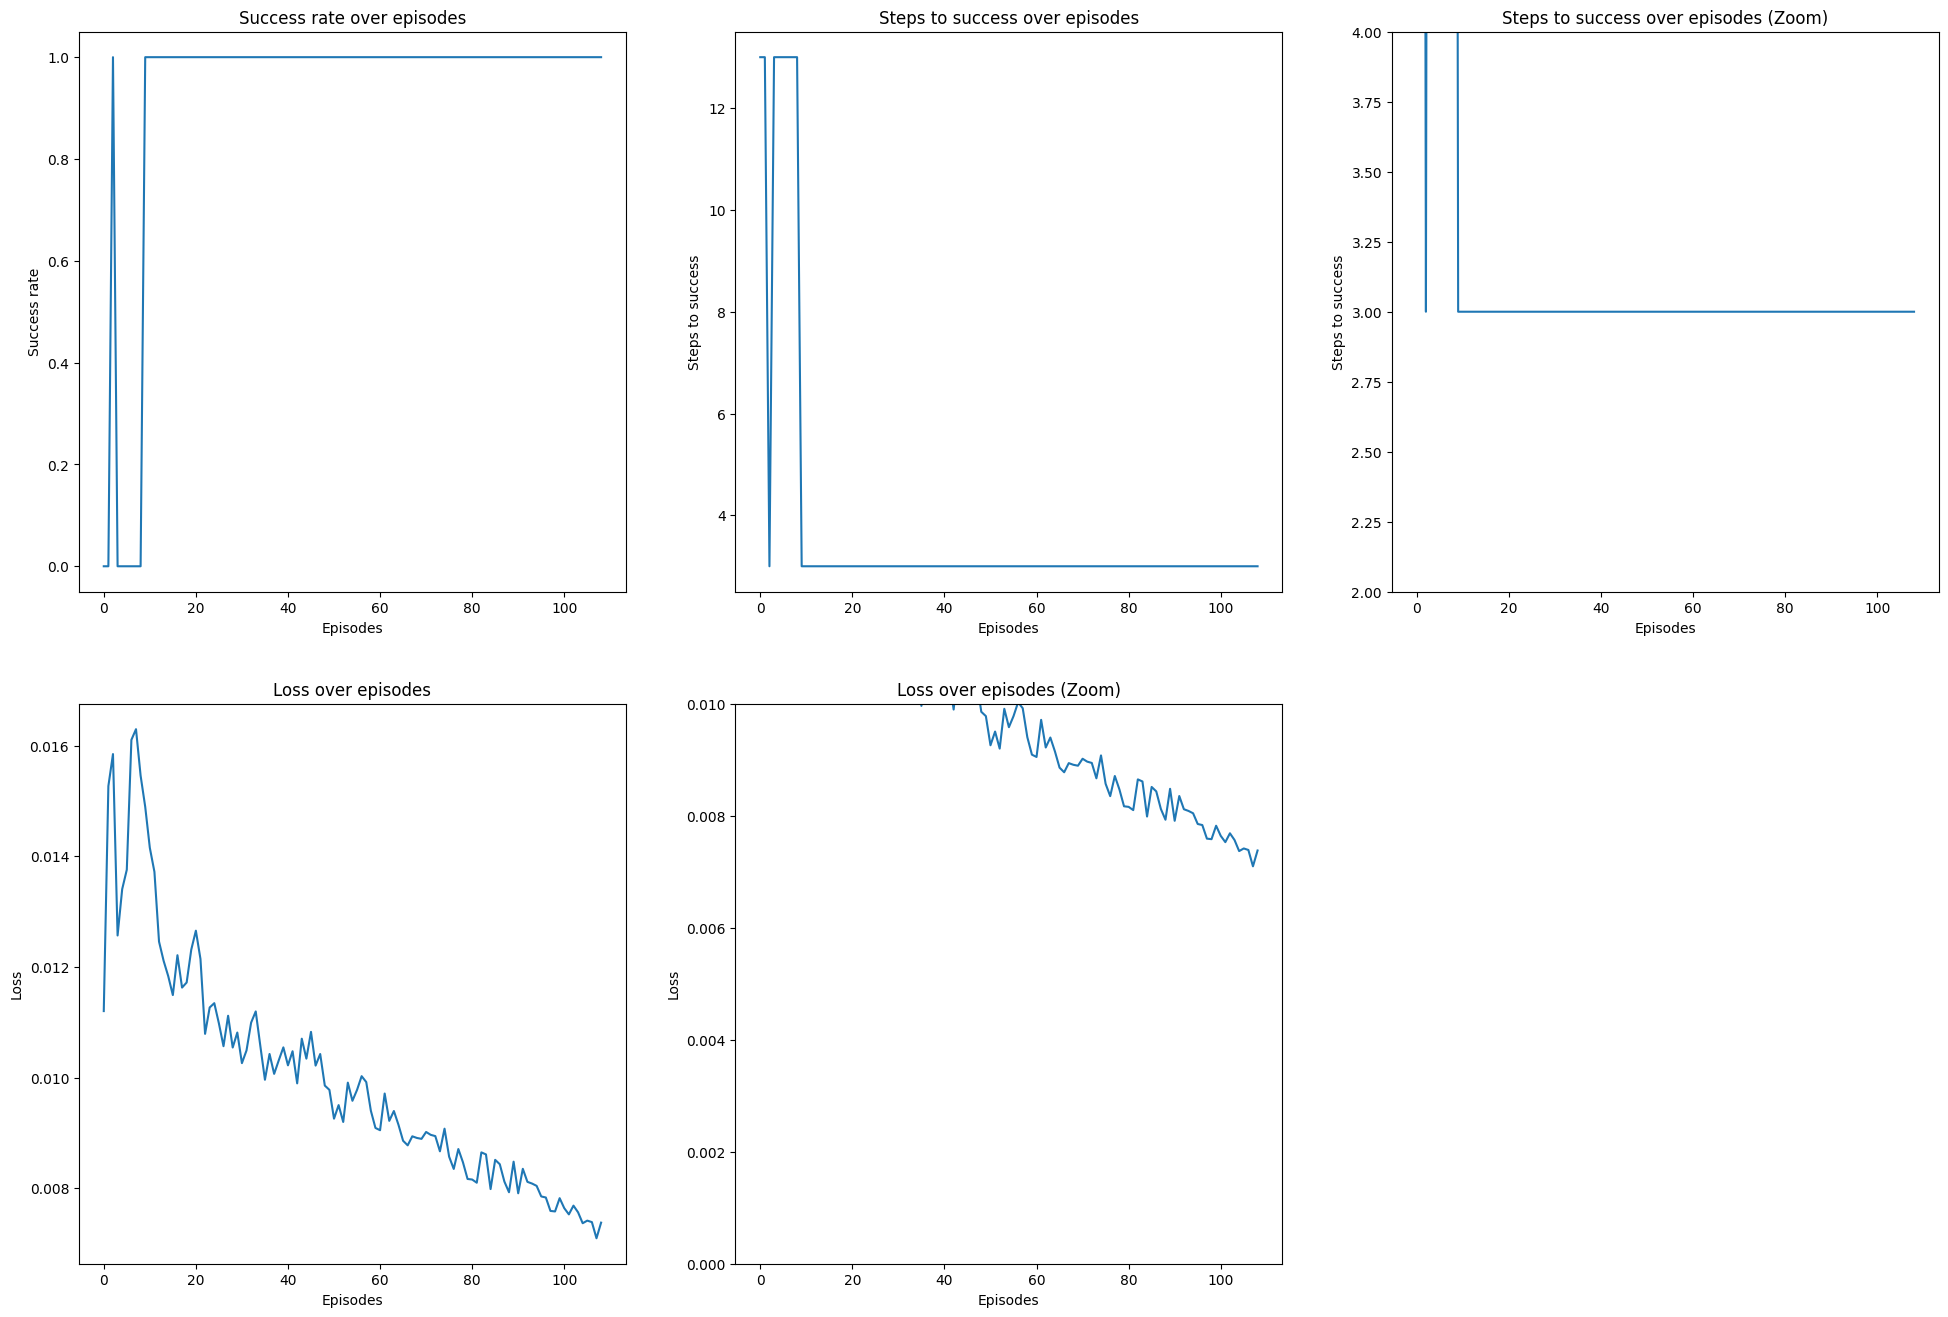

378


In [4]:
train_DQN_agent(6, device=device)

$n=10$, optimal agent achieved as steps $\sim 5$

Initialized FlippingBitSequenceEnv with n = 10. Randomly picked target: tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Initial distance to target: 3
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  1%|          | 105/10000 [00:04<05:37, 29.29it/s]

Episode: 99/10000, Epsilon: 0.9047921471137096, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.001627


  2%|▏         | 205/10000 [00:07<05:07, 31.82it/s]

Episode: 199/10000, Epsilon: 0.818648829478636, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.000828


  3%|▎         | 306/10000 [00:10<04:50, 33.41it/s]

Episode: 299/10000, Epsilon: 0.7407070321560997, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.000430


  4%|▍         | 406/10000 [00:13<04:50, 33.06it/s]

Episode: 399/10000, Epsilon: 0.6701859060067403, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.001512


  5%|▌         | 506/10000 [00:16<04:28, 35.37it/s]

Episode: 499/10000, Epsilon: 0.6063789448611848, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.000452


  6%|▌         | 607/10000 [00:19<04:29, 34.82it/s]

Episode: 599/10000, Epsilon: 0.5486469074854965, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.000424


  7%|▋         | 708/10000 [00:22<03:45, 41.16it/s]

Episode: 699/10000, Epsilon: 0.4964114134310989, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000434


  8%|▊         | 806/10000 [00:25<04:13, 36.30it/s]

Episode: 799/10000, Epsilon: 0.4491491486100748, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000770


  9%|▉         | 906/10000 [00:27<04:05, 37.04it/s]

Episode: 899/10000, Epsilon: 0.4063866225452039, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.000743


 10%|█         | 1008/10000 [00:30<03:55, 38.19it/s]

Episode: 999/10000, Epsilon: 0.3676954247709635, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000795


 11%|█         | 1108/10000 [00:33<03:34, 41.55it/s]

Episode: 1099/10000, Epsilon: 0.33268793286240766, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000430


 12%|█▏        | 1206/10000 [00:35<04:01, 36.39it/s]

Episode: 1199/10000, Epsilon: 0.3010134290933992, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.001114


 13%|█▎        | 1308/10000 [00:37<03:15, 44.47it/s]

Episode: 1299/10000, Epsilon: 0.27235458681947705, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000427


 14%|█▍        | 1408/10000 [00:40<03:23, 42.29it/s]

Episode: 1399/10000, Epsilon: 0.24642429138466176, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.000120


 15%|█▌        | 1508/10000 [00:42<03:19, 42.66it/s]

Episode: 1499/10000, Epsilon: 0.22296276370290227, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000760


 16%|█▌        | 1608/10000 [00:45<03:09, 44.25it/s]

Episode: 1599/10000, Epsilon: 0.20173495769715546, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000708


 17%|█▋        | 1704/10000 [00:47<03:23, 40.78it/s]

Episode: 1699/10000, Epsilon: 0.18252820552270246, Success rate: 0.00, Avg steps to success: 21.00, Loss: 0.000412


 18%|█▊        | 1807/10000 [00:49<02:55, 46.81it/s]

Episode: 1799/10000, Epsilon: 0.1651500869836984, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.001207


 19%|█▉        | 1907/10000 [00:51<02:53, 46.74it/s]

Episode: 1899/10000, Epsilon: 0.14942650179799613, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000129


 19%|█▉        | 1911/10000 [00:51<03:38, 37.05it/s]


Early stopping at episode 1911
Episode: 1911/10000, Epsilon: 0.14764321312555637, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000119


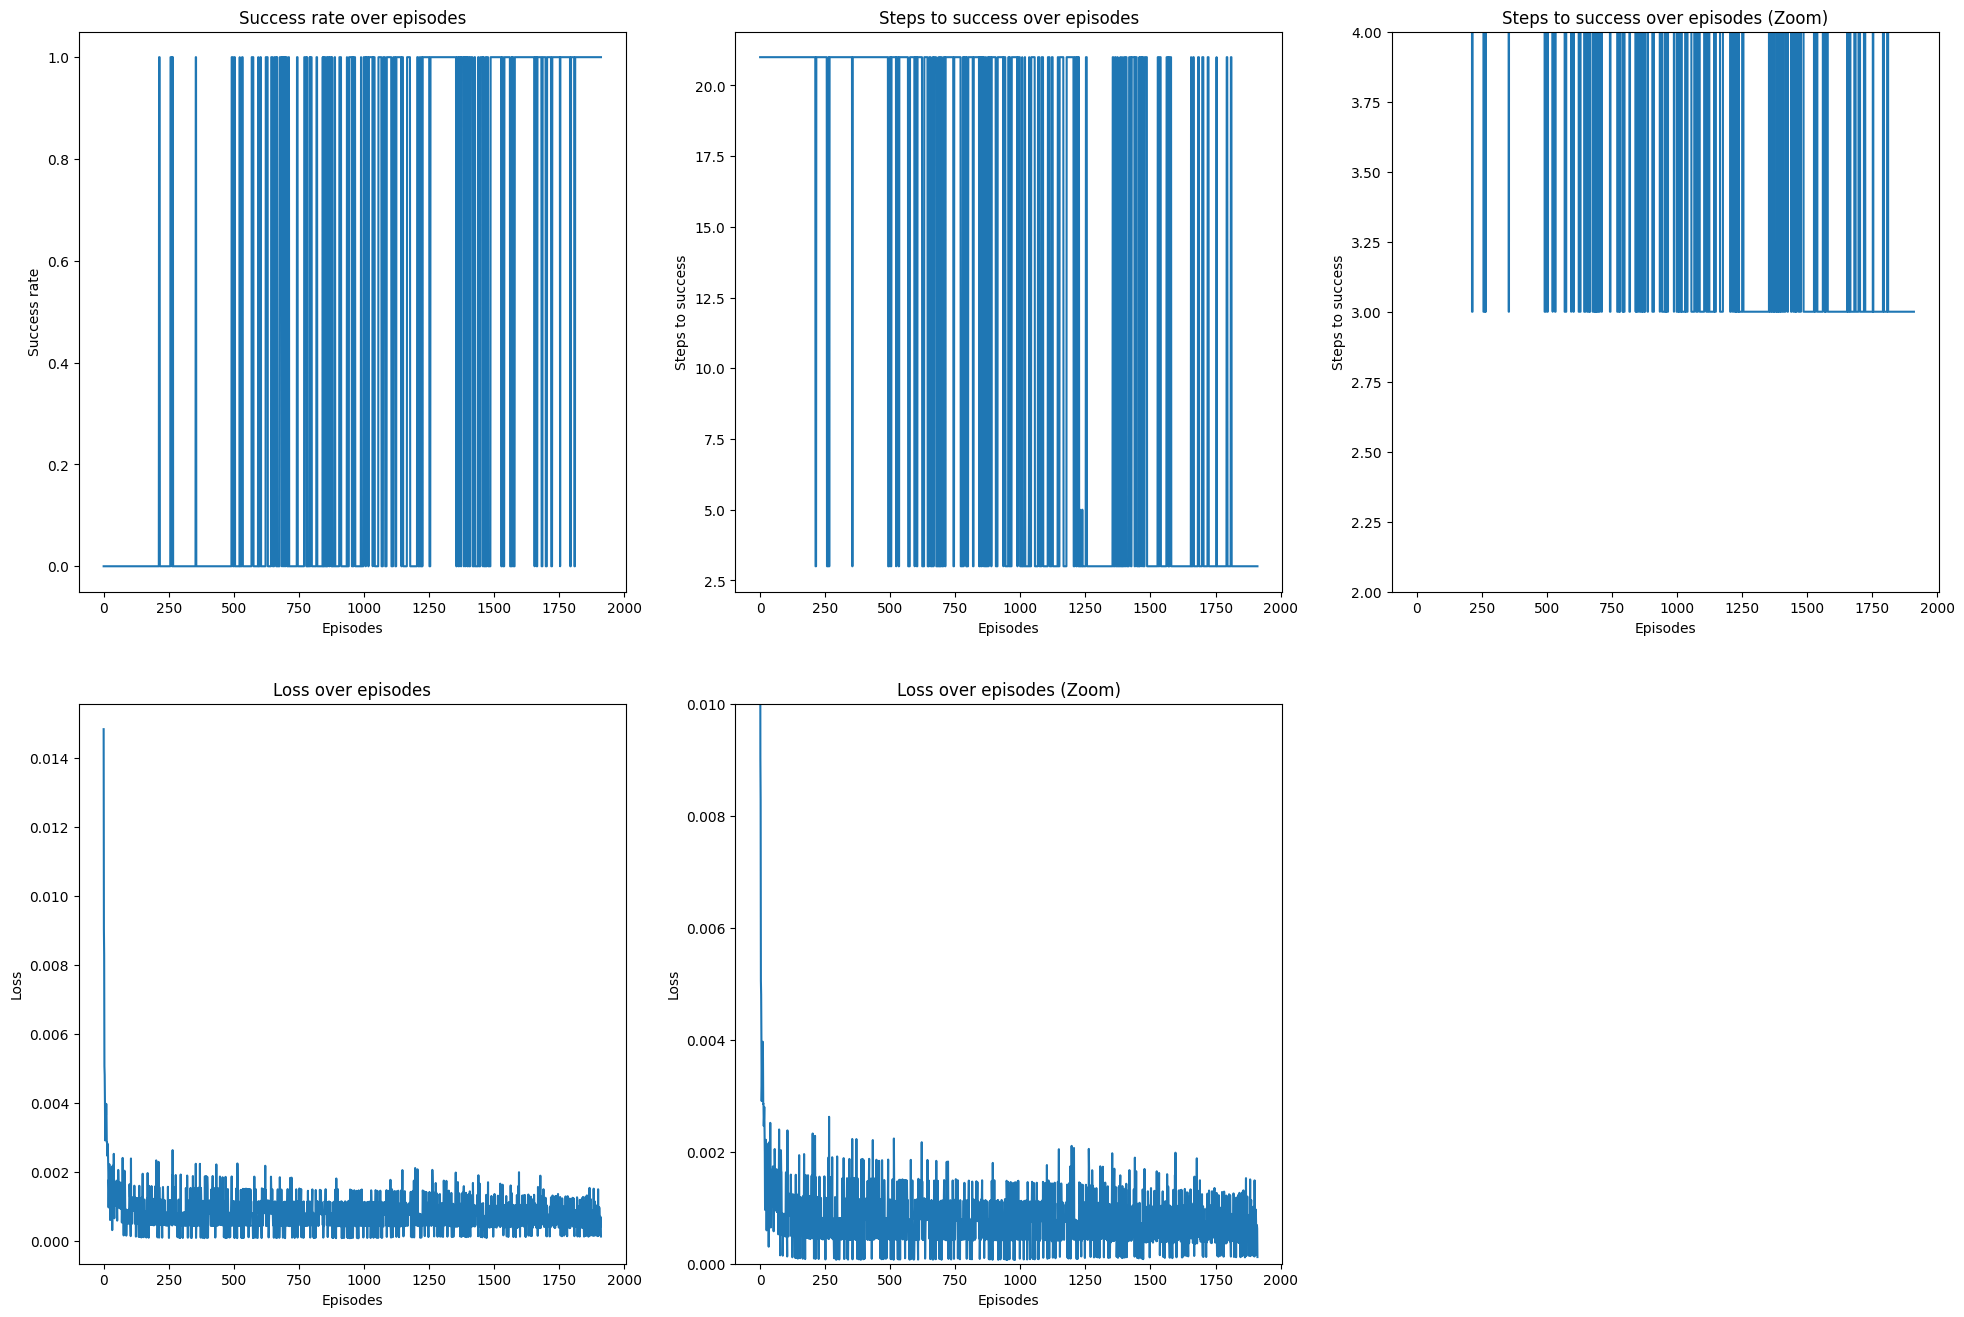

10136


In [5]:
train_DQN_agent(10, device=device)

$n=15$. Given more training epochs, an optimal agent could be found (avg steps 7.5)

Initialized FlippingBitSequenceEnv with n = 15. Randomly picked target: tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
Initial distance to target: 6
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  3%|▎         | 103/4000 [00:06<03:20, 19.46it/s]

Episode: 99/4000, Epsilon: 0.9047921471137096, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000121


  5%|▌         | 203/4000 [00:12<03:58, 15.95it/s]

Episode: 199/4000, Epsilon: 0.818648829478636, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000091


  8%|▊         | 301/4000 [00:18<04:13, 14.57it/s]

Episode: 299/4000, Epsilon: 0.7407070321560997, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000067


 10%|█         | 401/4000 [00:25<04:26, 13.49it/s]

Episode: 399/4000, Epsilon: 0.6701859060067403, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000057


 13%|█▎        | 501/4000 [00:32<04:13, 13.82it/s]

Episode: 499/4000, Epsilon: 0.6063789448611848, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000048


 15%|█▌        | 601/4000 [00:40<04:03, 13.94it/s]

Episode: 599/4000, Epsilon: 0.5486469074854965, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000041


 18%|█▊        | 701/4000 [00:47<03:52, 14.20it/s]

Episode: 699/4000, Epsilon: 0.4964114134310989, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000038


 20%|██        | 801/4000 [00:54<03:36, 14.75it/s]

Episode: 799/4000, Epsilon: 0.4491491486100748, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000032


 23%|██▎       | 903/4000 [01:00<03:21, 15.40it/s]

Episode: 899/4000, Epsilon: 0.4063866225452039, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000032


 25%|██▌       | 1003/4000 [01:07<03:10, 15.73it/s]

Episode: 999/4000, Epsilon: 0.3676954247709635, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000028


 28%|██▊       | 1103/4000 [01:13<03:02, 15.90it/s]

Episode: 1099/4000, Epsilon: 0.33268793286240766, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000032


 30%|███       | 1203/4000 [01:19<02:46, 16.76it/s]

Episode: 1199/4000, Epsilon: 0.3010134290933992, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000026


 33%|███▎      | 1303/4000 [01:25<02:39, 16.95it/s]

Episode: 1299/4000, Epsilon: 0.27235458681947705, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000026


 35%|███▌      | 1403/4000 [01:31<02:34, 16.82it/s]

Episode: 1399/4000, Epsilon: 0.24642429138466176, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000027


 38%|███▊      | 1503/4000 [01:37<02:23, 17.38it/s]

Episode: 1499/4000, Epsilon: 0.22296276370290227, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000022


 40%|████      | 1603/4000 [01:43<02:16, 17.54it/s]

Episode: 1599/4000, Epsilon: 0.20173495769715546, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000024


 43%|████▎     | 1703/4000 [01:49<02:08, 17.89it/s]

Episode: 1699/4000, Epsilon: 0.18252820552270246, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000022


 45%|████▌     | 1802/4000 [01:54<01:51, 19.75it/s]

Episode: 1799/4000, Epsilon: 0.1651500869836984, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000020


 48%|████▊     | 1902/4000 [01:59<01:53, 18.51it/s]

Episode: 1899/4000, Epsilon: 0.14942650179799613, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000337


 50%|█████     | 2002/4000 [02:04<01:40, 19.78it/s]

Episode: 1999/4000, Epsilon: 0.1351999253974994, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000023


 53%|█████▎    | 2102/4000 [02:09<01:36, 19.60it/s]

Episode: 2099/4000, Epsilon: 0.12232783079001676, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000021


 55%|█████▌    | 2203/4000 [02:14<01:29, 20.04it/s]

Episode: 2199/4000, Epsilon: 0.11068126067226178, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000023


 58%|█████▊    | 2304/4000 [02:19<01:21, 20.77it/s]

Episode: 2299/4000, Epsilon: 0.10014353548890782, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000017


 60%|██████    | 2403/4000 [02:24<01:18, 20.47it/s]

Episode: 2399/4000, Epsilon: 0.09060908449456685, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000021


 63%|██████▎   | 2502/4000 [02:29<01:13, 20.51it/s]

Episode: 2499/4000, Epsilon: 0.08198238810784661, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000020


 65%|██████▌   | 2601/4000 [02:34<01:08, 20.34it/s]

Episode: 2599/4000, Epsilon: 0.07417702096160789, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000017


 68%|██████▊   | 2703/4000 [02:39<01:01, 21.06it/s]

Episode: 2699/4000, Epsilon: 0.06711478606235186, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000020


 70%|███████   | 2802/4000 [02:43<00:56, 21.25it/s]

Episode: 2799/4000, Epsilon: 0.06072493138443261, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000021


 73%|███████▎  | 2904/4000 [02:48<00:51, 21.36it/s]

Episode: 2899/4000, Epsilon: 0.05494344105065345, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000017


 75%|███████▌  | 3003/4000 [02:53<00:46, 21.39it/s]

Episode: 2999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000016


 78%|███████▊  | 3102/4000 [02:57<00:41, 21.57it/s]

Episode: 3099/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000016


 80%|████████  | 3204/4000 [03:02<00:38, 20.88it/s]

Episode: 3199/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000018


 83%|████████▎ | 3303/4000 [03:07<00:32, 21.22it/s]

Episode: 3299/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000016


 85%|████████▌ | 3402/4000 [03:12<00:28, 20.94it/s]

Episode: 3399/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000013


 88%|████████▊ | 3504/4000 [03:17<00:23, 20.96it/s]

Episode: 3499/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000017


 90%|█████████ | 3603/4000 [03:21<00:18, 21.07it/s]

Episode: 3599/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000016


 93%|█████████▎| 3702/4000 [03:26<00:14, 21.15it/s]

Episode: 3699/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000014


 95%|█████████▌| 3804/4000 [03:31<00:09, 20.54it/s]

Episode: 3799/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000018


 98%|█████████▊| 3903/4000 [03:36<00:04, 21.29it/s]

Episode: 3899/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000013


100%|██████████| 4000/4000 [03:40<00:00, 18.12it/s]


Episode: 3999/4000, Epsilon: 0.05, Success rate: 0.00, Avg steps to success: 31.00, Loss: 0.000015


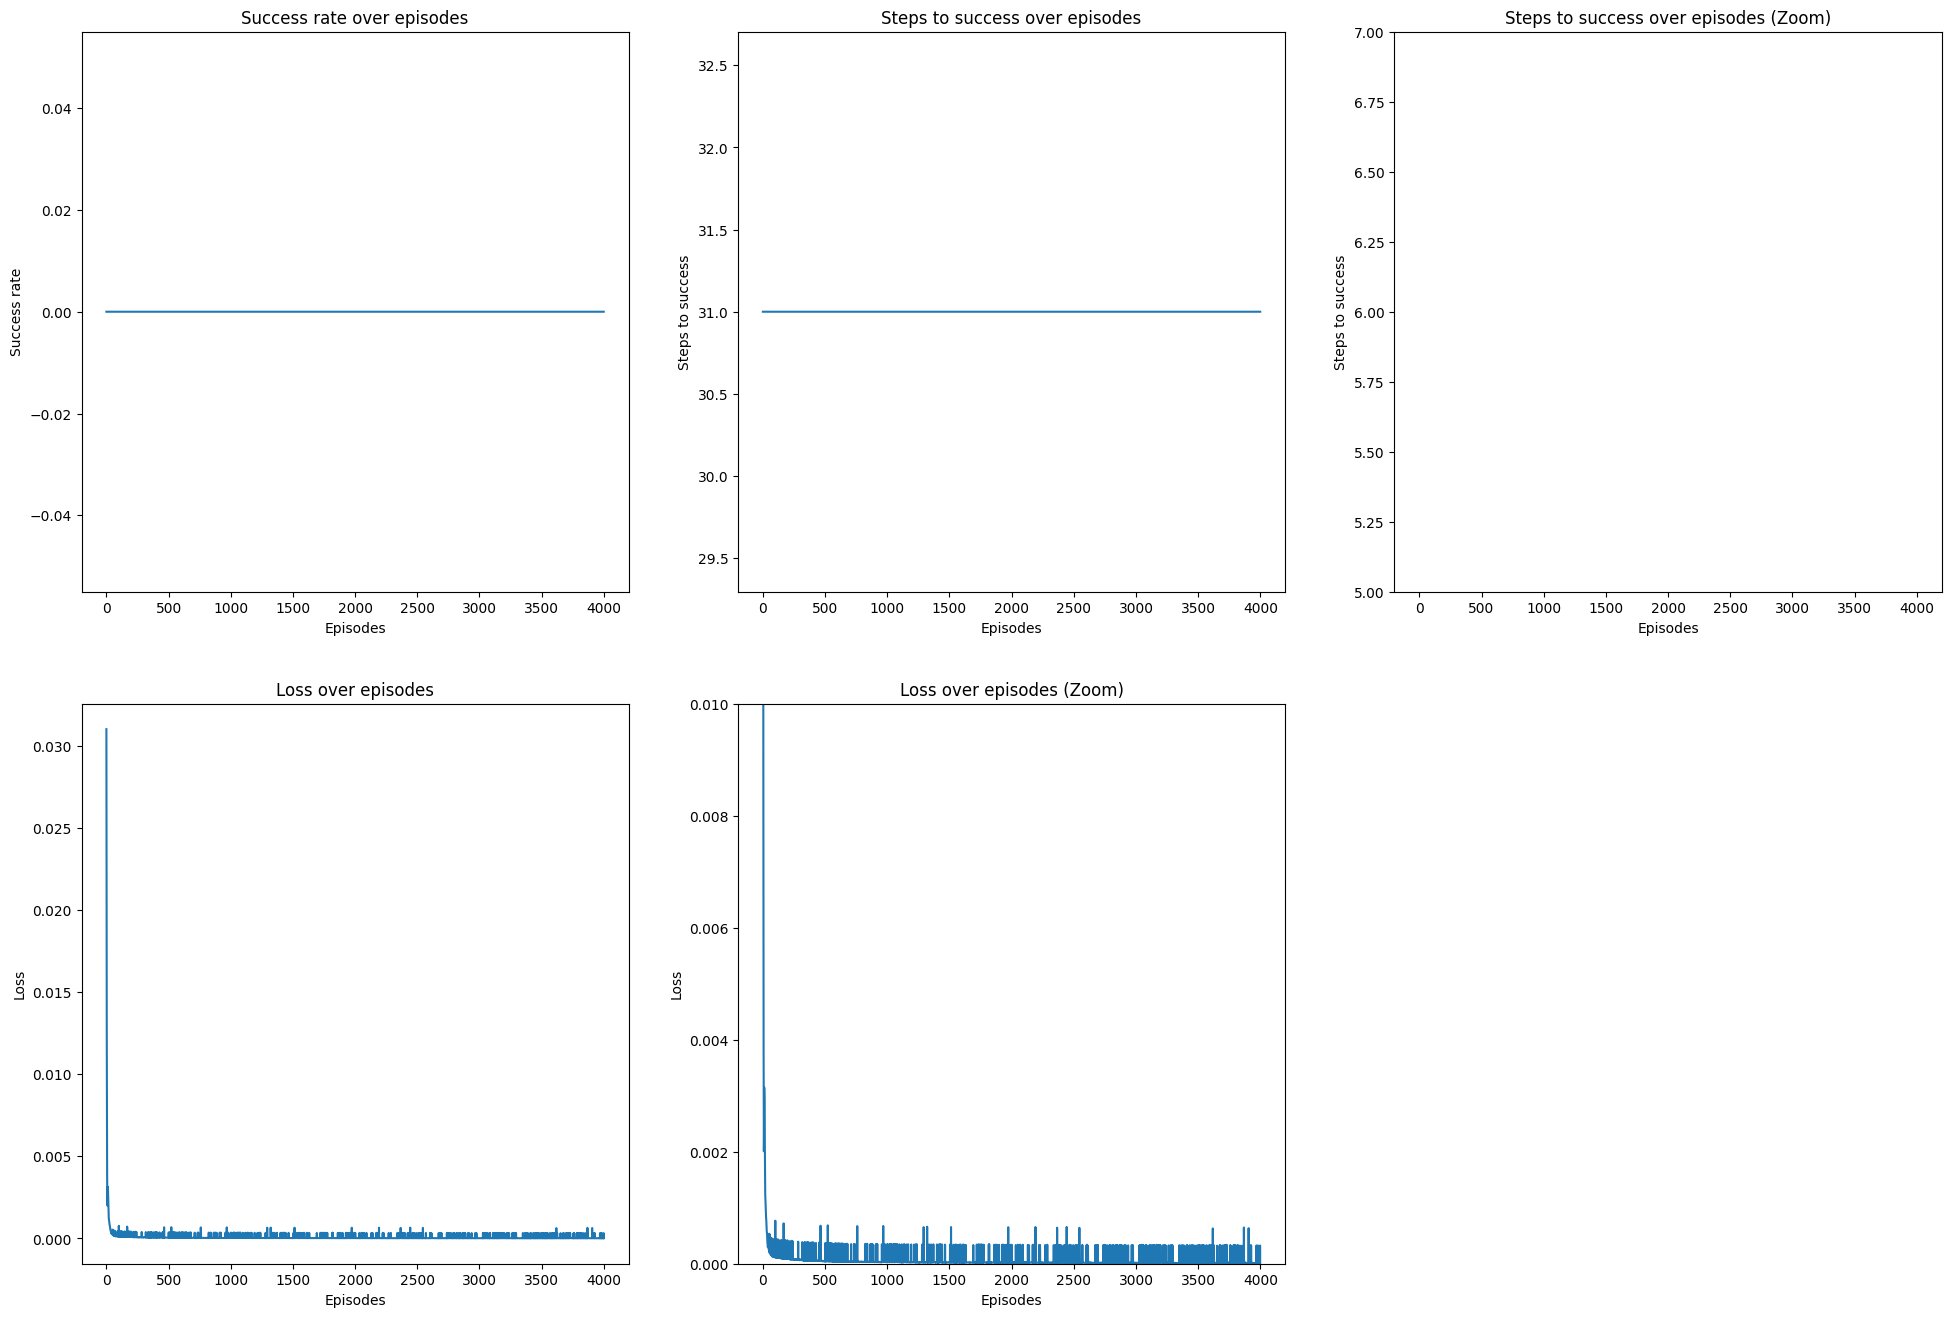

129491


In [6]:
train_DQN_agent(15, device=device, episodes=4000)

There are 16 agents in each episode, taking 50 steps max. Assuming that a randomly initialized Q-network gives rise to agents that pick actions at random uniformly, we expect that the procedure to visit 800 states. Note that $4000 \times 800 >> 2^{15}$, so it is possible that the state to be reached. In this case, we pick $n=30$, so $\frac{2^{30}}{800}=1342177.28$, and it is probabilistically unlikely that the target state will be visited from random exploration or from the randomly initialized Q-network policy.

$n=30$, as expected, the optimal agent cannot be found. This is due to the reward being too sparse.

In [7]:
train_DQN_agent(30, device=device, episodes=6000)

Initialized FlippingBitSequenceEnv with n = 30. Randomly picked target: tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0], device='cuda:0')
Initial distance to target: 16
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


  2%|▏         | 101/6000 [00:14<16:48,  5.85it/s]

Episode: 99/6000, Epsilon: 0.9047921471137096, Success rate: 0.00, Avg steps to success: 61.00, Loss: 0.000207


  2%|▏         | 107/6000 [00:15<17:38,  5.57it/s]